In [31]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Input
import pandas as pd
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
# from collections import Counter
# from conlleval import evaluate

print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")
else:
    strategy = tf.distribute.OneDeviceStrategy(device="/CPU:0")

Tensorflow version: 2.10.1
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
data = pd.read_csv('../kaggle/input/ner_datasetreference.csv', encoding = 'unicode_escape')
data[:40]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [3]:
data['Sentence #'] = data['Sentence #'].fillna(method='ffill')
data['Sentence #'] = data['Sentence #'].str.replace('Sentence: ', '').astype(int)
data = data.rename(columns={'Sentence #': 'Sentence'})
data = data[['Sentence', 'Word', 'Tag']]
data[:30]

,Sentence,Word,Tag
0,1,Thousands,O
1,1,of,O
2,1,demonstrators,O
3,1,have,O
4,1,marched,O
5,1,through,O
6,1,London,B-geo
7,1,to,O
8,1,protest,O
9,1,the,O


In [4]:
print(f"Number of unique entities: {len(data['Tag'].unique())}")
data['Tag'].unique()

Number of unique entities: 17


array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [5]:
words = list(set(data['Word'].values))
words.append("ENDPAD")
num_words = len(words)

tags = list(set(data['Tag'].values))
num_tags = len(tags)

In [6]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s['Word'].values.tolist(), s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Sentence').apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

# Init SentenceGetter object to preprocess and parse dataset into separate sentences
# 'sentences' object is an array of arrays, which contains tuples of word-entity pairs
getter = SentenceGetter(data)
sentences = getter.sentences
sentences[:1]

[[('Thousands', 'O'),
  ('of', 'O'),
  ('demonstrators', 'O'),
  ('have', 'O'),
  ('marched', 'O'),
  ('through', 'O'),
  ('London', 'B-geo'),
  ('to', 'O'),
  ('protest', 'O'),
  ('the', 'O'),
  ('war', 'O'),
  ('in', 'O'),
  ('Iraq', 'B-geo'),
  ('and', 'O'),
  ('demand', 'O'),
  ('the', 'O'),
  ('withdrawal', 'O'),
  ('of', 'O'),
  ('British', 'B-gpe'),
  ('troops', 'O'),
  ('from', 'O'),
  ('that', 'O'),
  ('country', 'O'),
  ('.', 'O')]]

In [7]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

max_len = data.groupby(['Sentence'], sort=False).size().max()

x = [[word2idx[w[0]] for w in s] for s in sentences]
x = pad_sequences(maxlen=max_len, sequences=x, padding="post", value=word2idx["ENDPAD"])

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx['O'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

## Transformer block and NER model creation

In [8]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        query = tf.reshape(
            tf.transpose(tf.reshape(query, (batch_size, -1, self.num_heads, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size * self.num_heads, -1, self.head_dim),
        )
        key = tf.reshape(
            tf.transpose(tf.reshape(key, (batch_size, -1, self.num_heads, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size * self.num_heads, -1, self.head_dim),
        )
        value = tf.reshape(
            tf.transpose(tf.reshape(value, (batch_size, -1, self.num_heads, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size * self.num_heads, -1, self.head_dim),
        )

        attention_logits = tf.matmul(query, key, transpose_b=True)
        attention_logits = attention_logits / tf.math.sqrt(tf.cast(self.head_dim, tf.float32))
        attention_weights = tf.nn.softmax(attention_logits, axis=-1)

        output = tf.matmul(attention_weights, value)
        output = tf.reshape(
            tf.transpose(tf.reshape(output, (batch_size, self.num_heads, -1, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size, -1, self.embed_dim),
        )
        output = self.combine_heads(output)
        return output

In [9]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output)
#         out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(attn_output)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(inputs + ffn_output)

In [10]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings

In [36]:
class NERModel(keras.Model):
    def __init__(
        self, num_tags, vocab_size, maxlen=128, embed_dim=32, num_heads=2, ff_dim=32, num_layers=1, rate=0.1
    ):
        super().__init__()
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
#         self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
        self.dropout1 = layers.Dropout(0.1)
        self.ff = layers.Dense(ff_dim, activation="relu")
        self.ff_final = layers.Dense(num_tags, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        x = self.dropout1(x, training=training)
        x = self.ff(x)
        x = self.ff_final(x)
        return x

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=1)

with strategy.scope():
    learning_rate = 0.0008
    optimizer = tf.keras.optimizers.RMSprop(learning_rate)
    ner_model = NERModel(num_tags, len(words), embed_dim=128, num_heads=2, ff_dim=num_tags*4, num_layers=2, rate=0.2)
    ner_model.compile(optimizer=optimizer, 
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])
    
    history = ner_model.fit(
        x=x_train,
        y=y_train,
        validation_split=0.1,
        batch_size=int(max_len/4),
        epochs=8,
        verbose=1,
        callbacks=[early_stop]
    )
    
    ner_model.summary()

Epoch 1/8
1329/1329 [==============================] - 29s 19ms/step - loss: 0.0562 - accuracy: 0.9855 - val_loss: 0.0348 - val_accuracy: 0.9904
Epoch 2/8
 836/1329 [=================>............] - ETA: 19s - loss: 0.0276 - accuracy: 0.9921

KeyboardInterrupt: 

In [13]:
import pickle
ner_model.save('../models/model_general_transformer/model',save_format="tf")
# ner_model.save_weights('../models/model_general_transformer/model')

# with open('../models/model_general_transformer/params.pickle', 'wb') as handle:
#     pickle.dump([num_tags, len(words)], handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../models/model_general_transformer/history.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../models/model_general_transformer/tags.pickle', 'wb') as handle:
    pickle.dump(tags, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../models/model_general_transformer/words.pickle', 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
# ner_model2 = NERModel(num_tags, len(words), embed_dim=128, num_heads=2, ff_dim=num_tags*4, num_layers=2, rate=0.2)
# ner_model2.load_weights('../models/model_general_transformer/model')

In [15]:
def plot_history(history):
    plt.style.use('ggplot')
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

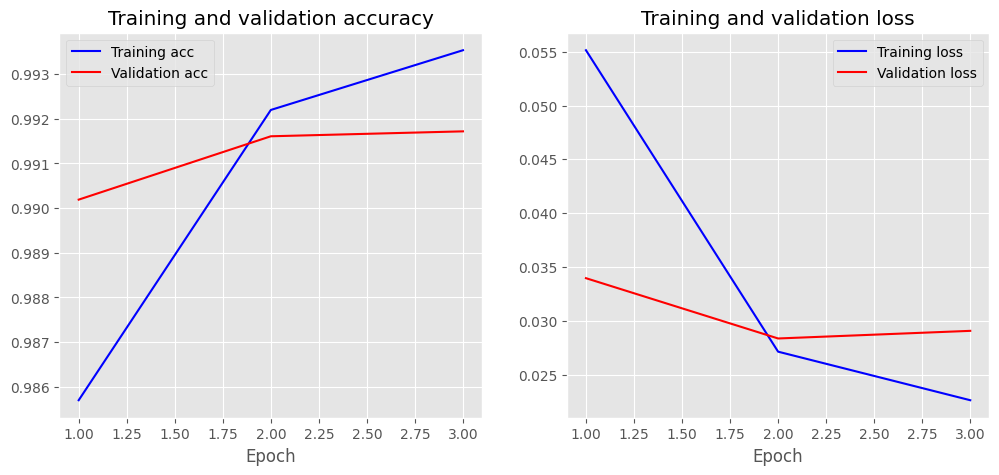

In [16]:
plot_history(history)

In [17]:
for i in range(3):
    p = ner_model.predict(np.array([x_test[i]]))
    p = np.argmax(p, axis=-1)
    y_true = y_test[i]
    print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
    print("-" * 30)
    for w, true, pred in zip(x_test[i], y_true, p[0]):
        if words[w] == "ENDPAD":
            break
        print("{:15}{}\t{}".format(words[w], tags[true], tags[pred]))
    print("----------------------------")

1/1 [==============================] - 1s 595ms/step
Word           True 	 Pred

------------------------------
President      B-per	B-per
Bush           I-per	I-per
has            O	O
not            O	O
ruled          O	O
out            O	O
the            O	O
possibility    O	O
,              O	O
but            O	O
Vice           O	B-per
President      B-per	B-per
Dick           I-per	I-per
Cheney         I-per	I-per
said           O	O
last           O	O
week           O	O
there          O	O
are            O	O
no             O	O
plans          O	O
to             O	O
shut           O	O
it             O	O
down           O	O
.              O	O
----------------------------
1/1 [==============================] - 0s 84ms/step
Word           True 	 Pred

------------------------------
Dr.            B-per	B-per
Besigye        I-per	I-per
still          O	O
faces          O	O
civilian       O	O
charges        O	O
of             O	O
rape           O	O
and            O	O
treason        O	O
.   